In [1]:
import os, json, gc
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy.stats import boxcox
from scipy.signal import resample

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error

# import lightgbm as lgb
# import optuna

import torch
from torch import nn

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.preprocess import EmgEncoder

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train = sio.loadmat("../data/train.mat")
test = sio.loadmat("../data/test.mat")
reference = sio.loadmat("../data/reference.mat")

print(reference.keys())

dict_keys(['__header__', '__version__', '__globals__', '0005'])


In [5]:
user_ids = ["0001", "0002", "0003", "0004"]

train_set = []
test_set = []
for i, user_id in enumerate(user_ids):
    train_data = np.load(f"../data/processed/train_{user_id}.npy")
    test_data = np.load(f"../data/processed/test_{user_id}.npy")
    
    train_set.append(train_data)
    test_set.append(test_data)

train_set[0].shape, test_set[0].shape

((319, 1000, 16), (319, 1000, 16))

In [6]:
y_set = [train[user_id][0][0][1].transpose(0, 2, 1) for user_id in user_ids]
# 正規化
y_scaler = []
for i, y in enumerate(y_set):
    mm = [y.max(), y.min()]
    y_scaler.append(mm)
    y_set[i] = (y - y.min()) / (y.max() - y.min())
y_set[0].shape

(319, 30, 3)

In [7]:
y_scaler

[[np.float64(3.505581889856), np.float64(-3.62248986231873)],
 [np.float64(3.48873985233063), np.float64(-3.42465783564102)],
 [np.float64(3.32337755825577), np.float64(-3.50604541489376)],
 [np.float64(3.60321377718699), np.float64(-3.803635192459)]]

In [8]:
class FullDataset(torch.utils.data.Dataset):
    def __init__(self, x_set: np.ndarray, y_set: np.ndarray, user_ids: list=None):
        super().__init__()
        self.x_set = x_set
        self.y_set = y_set
        
        if user_ids is not None:
            self.user_ids = user_ids
        else:
            self.user_ids = ["0001", "0002", "0003", "0004"]
        
        self.trials = [x.shape[0] for x in self.x_set]
        
    def __len__(self):
        return sum(self.trials)
    
    def __getitem__(self, idx):
        user_idx = 0
        # ユーザーの試行回数に応じてidxを再取得
        while idx >= self.trials[user_idx]:
            idx -= self.trials[user_idx]
            user_idx += 1
        
        x = self.x_set[user_idx][idx]
        y = self.y_set[user_idx][idx][:, 0]
        
        return x, y

train_dataset = FullDataset(train_set, y_set)
x, y = next(iter(train_dataset))
x.shape, y.shape

((1000, 16), (30,))

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
batch_size = 30
num_workers = 4
epochs = 30
learning_rate = 10e-3
valid_size = 0.2

torch.random.seed = 42
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [1-valid_size, valid_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(16000, 32000, dtype=torch.float32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32000, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1000, 100, dtype=torch.float32),
    nn.Dropout(0.3),
    # nn.ReLU(),
    nn.Linear(100, 30, dtype=torch.float32)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_1epoch():
    runnning_loss = 0
    
    for i, data in enumerate(train_loader):
        x, y = data
        x = x.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        optimizer.zero_grad()
        
        output = model(x)
        loss = loss_fn(output.to(torch.float32), y.to(torch.float32))
        loss.backward()
        
        optimizer.step()
        
        runnning_loss += loss.item()
    
    return runnning_loss / len(train_loader)

def valid_1epoch():
    valid_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y = y.to(torch.float32).to(device)
            
            pred = model(x).to(torch.float32)
            valid_loss += loss_fn(pred, y).item()
    return valid_loss / len(valid_loader)

train_history = {"train loss": [], "valid loss": []}
model.to(device)
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = train_1epoch()
    model.eval()
    valid_loss = valid_1epoch()
    print(f"[Epoch {epoch}] train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}")
    train_history["train loss"].append(train_loss)
    train_history["valid loss"].append(valid_loss)

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 0] train loss: 30401378.28814, valid loss: 0.40432
[Epoch 1] train loss: 0.47114, valid loss: 0.39342
[Epoch 2] train loss: 0.77622, valid loss: 0.39007
[Epoch 3] train loss: 0.40831, valid loss: 0.38656


KeyboardInterrupt: 

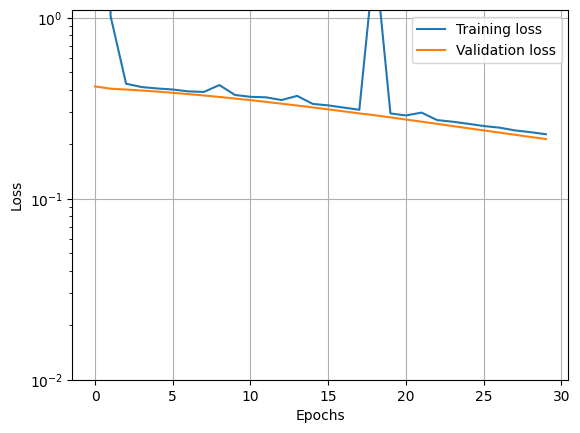

In [11]:
plt.plot(train_history["train loss"], label="Training loss")
plt.plot(train_history["valid loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0.01, 1.1])
plt.yscale("log")
plt.grid()
plt.show()

In [12]:
torch.save(model, "../models/mlp.pt")

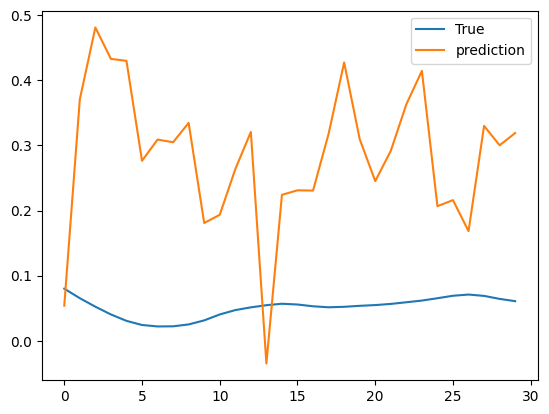

In [17]:
model.to("cpu")
valid_x, valid_y = next(iter(valid_dataset))
valid_x = torch.tensor(valid_x, dtype=torch.float32)
valid_x = valid_x.unsqueeze(0)
model.eval()
pred = model(valid_x)
pred = pred.detach().numpy()[0]
plt.plot(valid_y, label="True")
plt.plot(pred, label="prediction")
plt.legend()
plt.show()

# Reference (Player: 0005) で検証

In [1]:
import os, json
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import scipy.io as sio
from sklearn.model_selection import KFold

In [2]:
import sys
sys.path.append("..")
from src.preprocess import EmgEncoder

## データの前処理

In [3]:
reference = sio.loadmat("../data/reference.mat")

train_encoder = EmgEncoder()
train_x = reference["0005"][0][0][0]
train_y = reference["0005"][0][0][1]
test_x = reference["0005"][0][0][2]
test_y = reference["0005"][0][0][3]

train_x = train_encoder.fit_transform(train_x)
y_scaler = [train_y.max(), train_y.min()]
train_y = (train_y - y_scaler[1]) / (y_scaler[0] - y_scaler[1])
train_y = train_y.transpose(0, 2, 1)

test_x = train_encoder.transform(test_x)
test_y = (test_y - y_scaler[1]) / (y_scaler[0] - y_scaler[1])
test_y = test_y.transpose(0, 2, 1)


train_x.shape, test_x.shape, train_y.shape, test_y.shape

((320, 1000, 16), (320, 1000, 16), (320, 30, 3), (320, 30, 3))

## モデルの定義

In [4]:
def compile_model(dropout: float=0.1):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(16000, 32000, dtype=torch.float32),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(32000, 1000, dtype=torch.float32),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(1000, 500, dtype=torch.float32),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(500, 100, dtype=torch.float32),
        nn.Dropout(dropout),
        # nn.ReLU(),
        nn.Tanh(),
        nn.Linear(100, 30, dtype=torch.float32)
    )   
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer, loss_function

def compile_model2(dropout: float=0.2):
    model = nn.Sequential(
        nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(30),
        nn.Flatten(start_dim=1),
        nn.Linear(128*30, 30),
    )
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer, loss_function

def compile_model3(dropout: float=0.2):
    model = nn.Sequential(
        # Conv1D層1: 入力チャンネル16 -> 出力チャンネル64
        nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm1d(64),  # バッチ正規化
        nn.ReLU(),
        
        # Conv1D層2: 入力チャンネル64 -> 出力チャンネル128
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm1d(128),  # バッチ正規化
        nn.ReLU(),
        
        # Conv1D層3: 入力チャンネル128 -> 出力チャンネル256
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm1d(256),  # バッチ正規化
        nn.ReLU(),
        
        # プーリング層で時系列を30に縮小
        nn.AdaptiveMaxPool1d(30),
        
        nn.Flatten(start_dim=1),
        
        # 全結合層1: 入力256 * 30 -> 隠れ層512
        nn.Linear(256 * 30, 512),
        nn.Tanh(),
        nn.Dropout(dropout),        
        nn.Linear(512, 30)
    )

    # 損失関数と最適化関数
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, optimizer, loss_function

def train_1epoch(model, loss_fn, optimizer, train_loader):
    total_loss = 0
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def valid_1epoch(model, loss_fn, valid_loader):
    total_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_loader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            total_loss += loss_fn(pred, y).item()
        
    return total_loss / len(valid_loader)

def predict(model, test_loader):
    results = {"true": [], "pred": []}
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)

            results["true"].append(y.to("cpu"))
            results["pred"].append(pred.to("cpu"))
    return results

## Datasetの作成

In [5]:
class RefDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, y_axis: int=0):
        super().__init__()
        self.x = x
        self.y = y
        self.y_axis = y_axis
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx, :, :].transpose(1, 0), dtype=torch.float32)
        y = torch.tensor(self.y[idx, :, self.y_axis], dtype=torch.float32)
        
        return x, y

## KFold CV

In [30]:
batch_size = 30
dropout = 0.3
epochs = 100
hidden_state = [32000, 1000, 500, 100]
learning_rate = 10e-3
num_layers = 4
num_splits = 5
num_workers = 12

axis = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = RefDataset(train_x, train_y, y_axis=0)
test_dataset = RefDataset(test_x, test_y, y_axis=0)

pred_results = []
history = []
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(kf.split(range(len(dataset)))):
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    valid_dataset = torch.utils.data.Subset(dataset, valid_idx)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=num_workers,
        shuffle=False
    )
    
    # model, optimizer, loss_fn = compile_model(dropout=dropout, num_layer=num_layers, hidden_state=hidden_state)
    model, optimizer, loss_fn = compile_model2(dropout=dropout)
    # model, optimizer, loss_fn = compile_model3(dropout=dropout)
    
    model.to(device)
    history_1epoch = {"train": [], "valid": []}
    best_value = 10e9
    best_epoch = 0
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = train_1epoch(model, loss_fn, optimizer, train_loader)
        model.eval()
        valid_loss = valid_1epoch(model, loss_fn, valid_loader)
        print(f"[Epoch {epoch}] train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}")
        history_1epoch["train"].append(train_loss)
        history_1epoch["valid"].append(valid_loss)
        
        if valid_loss < best_value:
            print(f"+++++ Saved as Best-Epoch: {epoch} ++++++")
            torch.save(model, f"../models/Fold{i}_Axis{axis}_BestEpoch.pt")
            best_value = valid_loss
            best_epoch = epoch
            
        
    results = predict(model, test_loader)
    pred_results.append(results)
    history.append(history_1epoch)
    
    torch.save(model, f"../models/Fold{i}_Axis{axis}_FinalEpoch.pt")
    print("=======================================")
    print(f"  Best epoch: {epoch}, valid loss: {best_value:.5f}")
    print("=======================================")
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train loss: 2.33535, valid loss: 0.22076
+++++ Saved as Best-Epoch: 0 ++++++
[Epoch 1] train loss: 0.12313, valid loss: 0.11615
+++++ Saved as Best-Epoch: 1 ++++++
[Epoch 2] train loss: 0.10921, valid loss: 0.11573
+++++ Saved as Best-Epoch: 2 ++++++
[Epoch 3] train loss: 0.10304, valid loss: 0.11322
+++++ Saved as Best-Epoch: 3 ++++++
[Epoch 4] train loss: 0.09572, valid loss: 0.11768
[Epoch 5] train loss: 0.09575, valid loss: 0.10155
+++++ Saved as Best-Epoch: 5 ++++++
[Epoch 6] train loss: 0.10050, valid loss: 0.10814
[Epoch 7] train loss: 0.08687, valid loss: 0.09642
+++++ Saved as Best-Epoch: 7 ++++++
[Epoch 8] train loss: 0.07300, valid loss: 0.06899
+++++ Saved as Best-Epoch: 8 ++++++
[Epoch 9] train loss: 0.05299, valid loss: 0.05838
+++++ Saved as Best-Epoch: 9 ++++++
[Epoch 10] train loss: 0.04223, valid loss: 0.04545
+++++ Saved as Best-Epoch: 10 ++++++
[Epoch 11] train loss: 0.04511, valid loss: 0.05743
[Epoch 12] train loss: 0.04407, valid loss: 0.04500
+++++ Sav

  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train loss: 2.37789, valid loss: 0.09550
+++++ Saved as Best-Epoch: 0 ++++++
[Epoch 1] train loss: 0.18050, valid loss: 0.14300
[Epoch 2] train loss: 0.12340, valid loss: 0.08992
+++++ Saved as Best-Epoch: 2 ++++++
[Epoch 3] train loss: 0.11709, valid loss: 0.09232
[Epoch 4] train loss: 0.09880, valid loss: 0.07859
+++++ Saved as Best-Epoch: 4 ++++++
[Epoch 5] train loss: 0.09665, valid loss: 0.06624
+++++ Saved as Best-Epoch: 5 ++++++
[Epoch 6] train loss: 0.06831, valid loss: 0.04007
+++++ Saved as Best-Epoch: 6 ++++++
[Epoch 7] train loss: 0.04304, valid loss: 0.03050
+++++ Saved as Best-Epoch: 7 ++++++
[Epoch 8] train loss: 0.03705, valid loss: 0.05056
[Epoch 9] train loss: 0.03899, valid loss: 0.03189
[Epoch 10] train loss: 0.03565, valid loss: 0.02572
+++++ Saved as Best-Epoch: 10 ++++++
[Epoch 11] train loss: 0.03472, valid loss: 0.06926
[Epoch 12] train loss: 0.04774, valid loss: 0.02600
[Epoch 13] train loss: 0.03431, valid loss: 0.02378
+++++ Saved as Best-Epoch: 13

  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train loss: 3.70715, valid loss: 0.12876
+++++ Saved as Best-Epoch: 0 ++++++
[Epoch 1] train loss: 0.13540, valid loss: 0.09168
+++++ Saved as Best-Epoch: 1 ++++++
[Epoch 2] train loss: 0.11109, valid loss: 0.08715
+++++ Saved as Best-Epoch: 2 ++++++
[Epoch 3] train loss: 0.10196, valid loss: 0.07911
+++++ Saved as Best-Epoch: 3 ++++++
[Epoch 4] train loss: 0.10708, valid loss: 0.07640
+++++ Saved as Best-Epoch: 4 ++++++
[Epoch 5] train loss: 0.09786, valid loss: 0.08733
[Epoch 6] train loss: 0.09468, valid loss: 0.07699
[Epoch 7] train loss: 0.09089, valid loss: 0.06463
+++++ Saved as Best-Epoch: 7 ++++++
[Epoch 8] train loss: 0.08101, valid loss: 0.06307
+++++ Saved as Best-Epoch: 8 ++++++
[Epoch 9] train loss: 0.07904, valid loss: 0.06350
[Epoch 10] train loss: 0.07190, valid loss: 0.05686
+++++ Saved as Best-Epoch: 10 ++++++
[Epoch 11] train loss: 0.04479, valid loss: 0.03479
+++++ Saved as Best-Epoch: 11 ++++++
[Epoch 12] train loss: 0.03623, valid loss: 0.04000
[Epoch 1

  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train loss: 1.76190, valid loss: 0.17725
+++++ Saved as Best-Epoch: 0 ++++++
[Epoch 1] train loss: 0.13631, valid loss: 0.12995
+++++ Saved as Best-Epoch: 1 ++++++
[Epoch 2] train loss: 0.11192, valid loss: 0.10711
+++++ Saved as Best-Epoch: 2 ++++++
[Epoch 3] train loss: 0.11511, valid loss: 0.12098
[Epoch 4] train loss: 0.12336, valid loss: 0.08823
+++++ Saved as Best-Epoch: 4 ++++++
[Epoch 5] train loss: 0.12070, valid loss: 0.08709
+++++ Saved as Best-Epoch: 5 ++++++
[Epoch 6] train loss: 0.10922, valid loss: 0.10640
[Epoch 7] train loss: 0.09944, valid loss: 0.08573
+++++ Saved as Best-Epoch: 7 ++++++
[Epoch 8] train loss: 0.09098, valid loss: 0.07048
+++++ Saved as Best-Epoch: 8 ++++++
[Epoch 9] train loss: 0.08557, valid loss: 0.07425
[Epoch 10] train loss: 0.08857, valid loss: 0.06306
+++++ Saved as Best-Epoch: 10 ++++++
[Epoch 11] train loss: 0.08840, valid loss: 0.05444
+++++ Saved as Best-Epoch: 11 ++++++
[Epoch 12] train loss: 0.08366, valid loss: 0.05361
+++++ Sa

  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train loss: 9.91088, valid loss: 0.26325
+++++ Saved as Best-Epoch: 0 ++++++
[Epoch 1] train loss: 0.18160, valid loss: 0.09348
+++++ Saved as Best-Epoch: 1 ++++++
[Epoch 2] train loss: 0.09683, valid loss: 0.08970
+++++ Saved as Best-Epoch: 2 ++++++
[Epoch 3] train loss: 0.09409, valid loss: 0.08728
+++++ Saved as Best-Epoch: 3 ++++++
[Epoch 4] train loss: 0.08627, valid loss: 0.07588
+++++ Saved as Best-Epoch: 4 ++++++
[Epoch 5] train loss: 0.07709, valid loss: 0.07827
[Epoch 6] train loss: 0.07307, valid loss: 0.06610
+++++ Saved as Best-Epoch: 6 ++++++
[Epoch 7] train loss: 0.05613, valid loss: 0.07013
[Epoch 8] train loss: 0.06992, valid loss: 0.10268
[Epoch 9] train loss: 0.04853, valid loss: 0.05540
+++++ Saved as Best-Epoch: 9 ++++++
[Epoch 10] train loss: 0.05354, valid loss: 0.04803
+++++ Saved as Best-Epoch: 10 ++++++
[Epoch 11] train loss: 0.04621, valid loss: 0.04724
+++++ Saved as Best-Epoch: 11 ++++++
[Epoch 12] train loss: 0.04173, valid loss: 0.04390
+++++ Sa

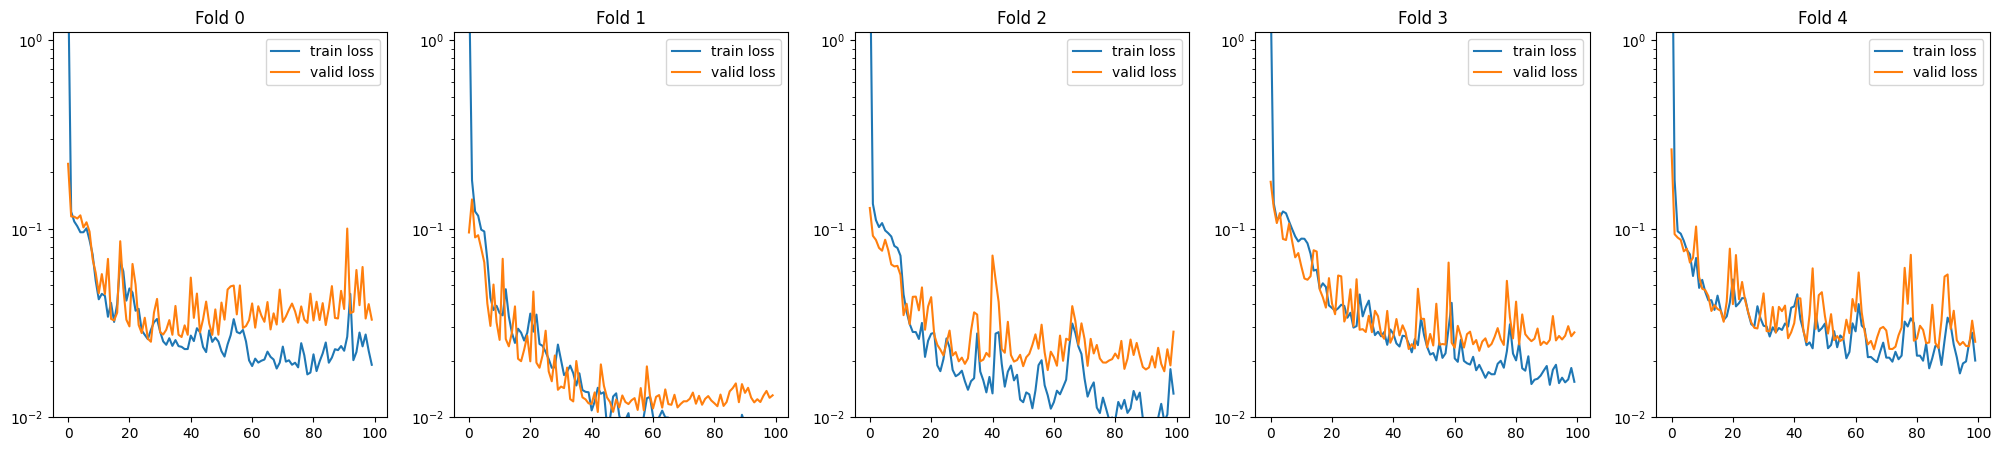

In [31]:
fig = plt.figure(figsize=(25, 5))
for i in range(num_splits):
    ax = fig.add_subplot(1, num_splits, i+1)
    ax.plot(history[i]["train"], label="train loss")
    ax.plot(history[i]["valid"], label="valid loss")
    ax.set_title(f"Fold {i}")
    ax.set_ylim([0.01, 1.1])
    ax.set_yscale("log")
    ax.legend()
plt.show()

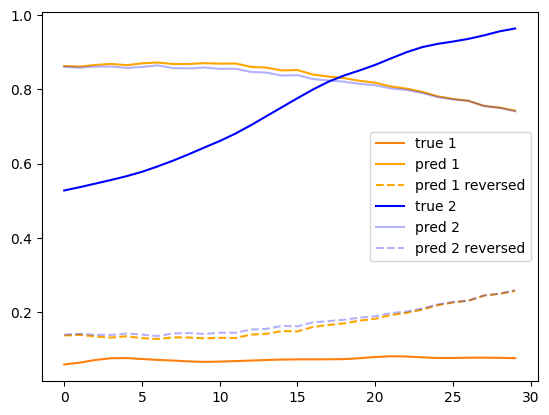

In [49]:
sample_id_1 = 1
sample_id_2 = 9
plt.plot(pred_results[0]["true"][sample_id_1][0], label="true 1", color="C1")
plt.plot(pred_results[0]["pred"][sample_id_1][0], label="pred 1", color="orange")
plt.plot((pred_results[0]["pred"][sample_id_1][0] - 1) * -1, label="pred 1 reversed", ls="--", color="orange")


plt.plot(pred_results[0]["true"][sample_id_2][0], label="true 2", color="blue")
plt.plot(pred_results[0]["pred"][sample_id_2][0], label="pred 2", color="blue", alpha=0.3)
plt.plot((pred_results[0]["pred"][sample_id_2][0] - 1) * -1, label="pred 2 reversed", color="blue", ls="--", alpha=0.3)

plt.legend()

## 学習データと予測値

/tmp/ipykernel_75793/828188601.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


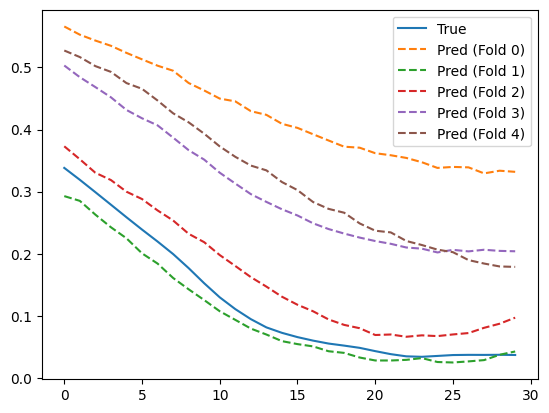

In [33]:
sample_id_1 = 1

sample_x = train_x[sample_id_1, :, :].transpose(1, 0).reshape(1, 16, 1000)
sample_y = train_y[sample_id_1, :, 0]
plt.plot(sample_y, label="True")
for i in range(num_splits):
    model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")
    model.to("cpu")
    pred_y = model(torch.tensor(sample_x, dtype=torch.float32)).detach().numpy()

    plt.plot(pred_y[0], label=f"Pred (Fold {i})", ls="--")

plt.legend()
plt.show()

/tmp/ipykernel_75793/1983549850.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


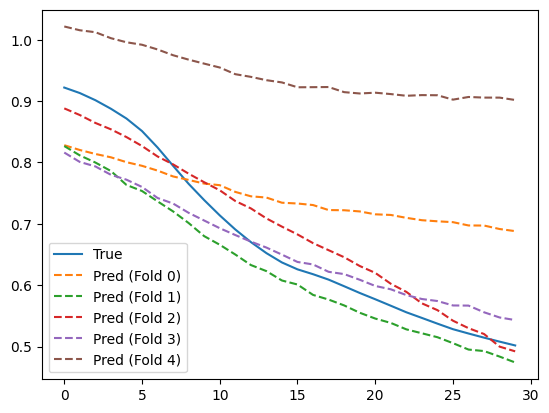

In [34]:
sample_id_1 = 8

sample_x = train_x[sample_id_1, :, :].transpose(1, 0).reshape(1, 16, 1000)
sample_y = train_y[sample_id_1, :, 0]
plt.plot(sample_y, label="True")
for i in range(num_splits):
    model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")
    model.to("cpu")
    pred_y = model(torch.tensor(sample_x, dtype=torch.float32)).detach().numpy()

    plt.plot(pred_y[0], label=f"Pred (Fold {i})", ls="--")

plt.legend()
plt.show()

## 評価データと予測値

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


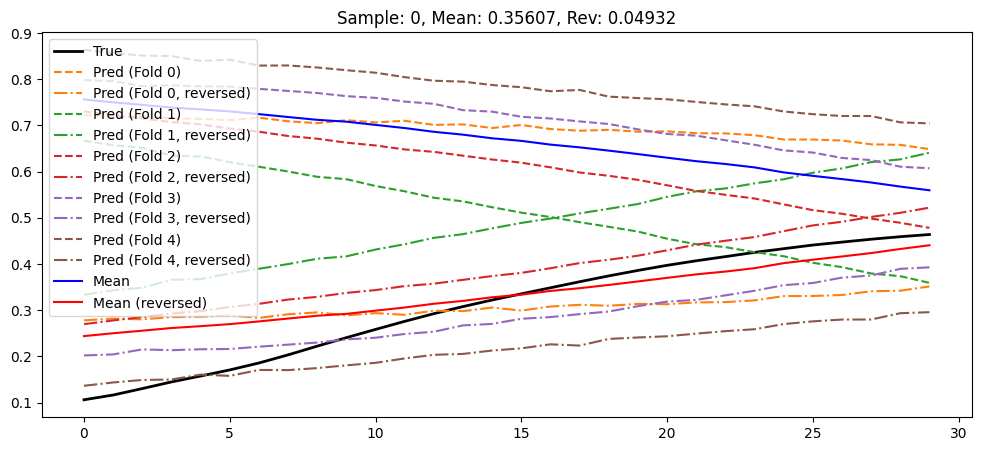

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


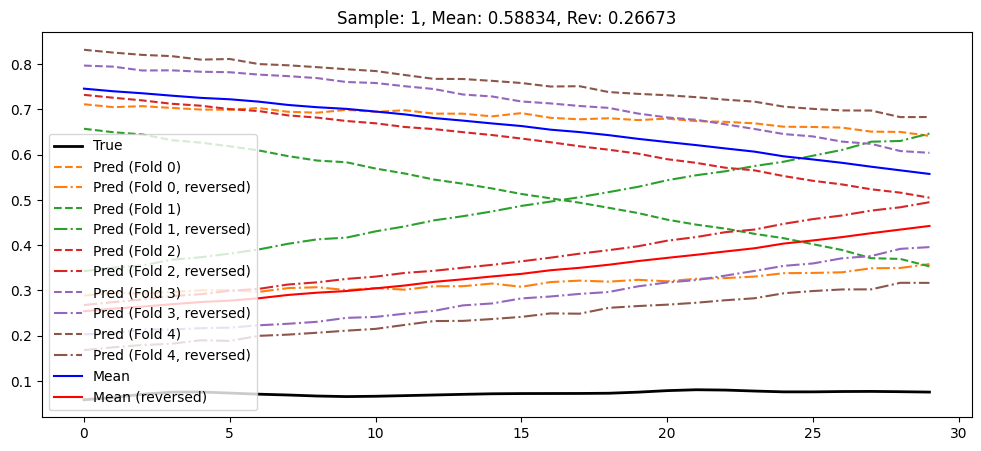

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


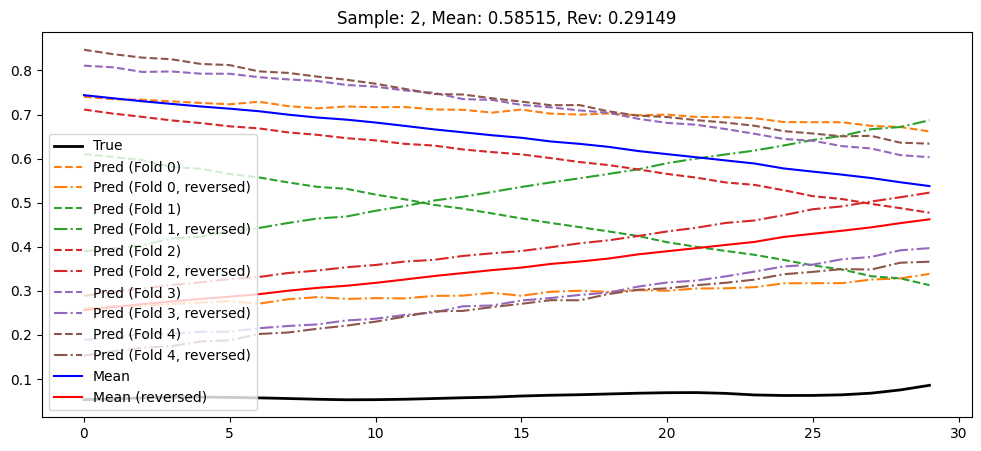

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


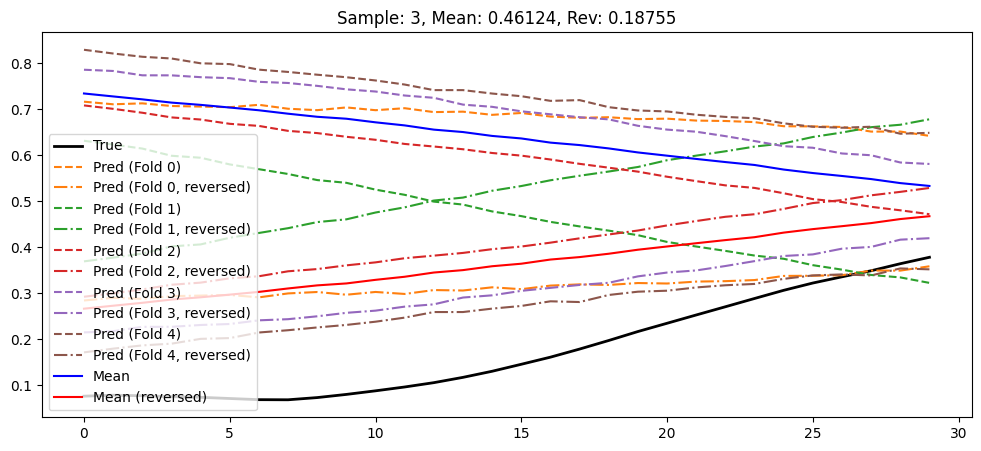

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


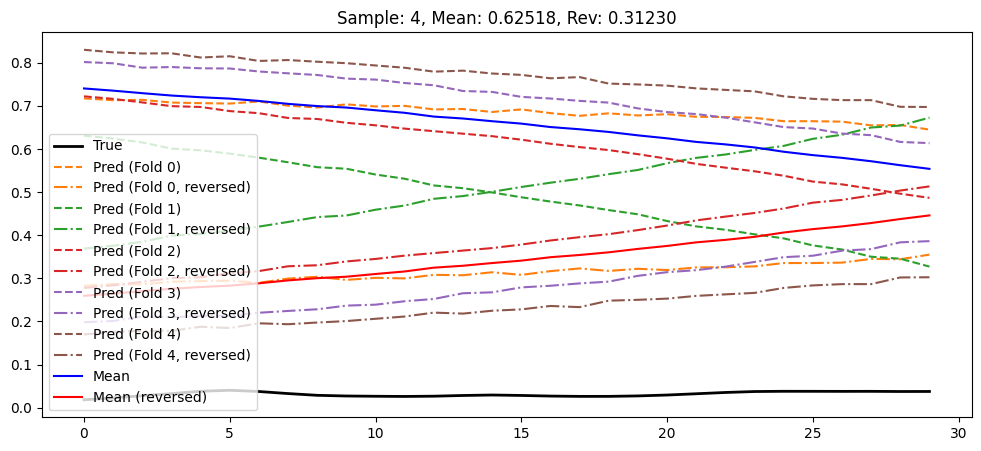

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


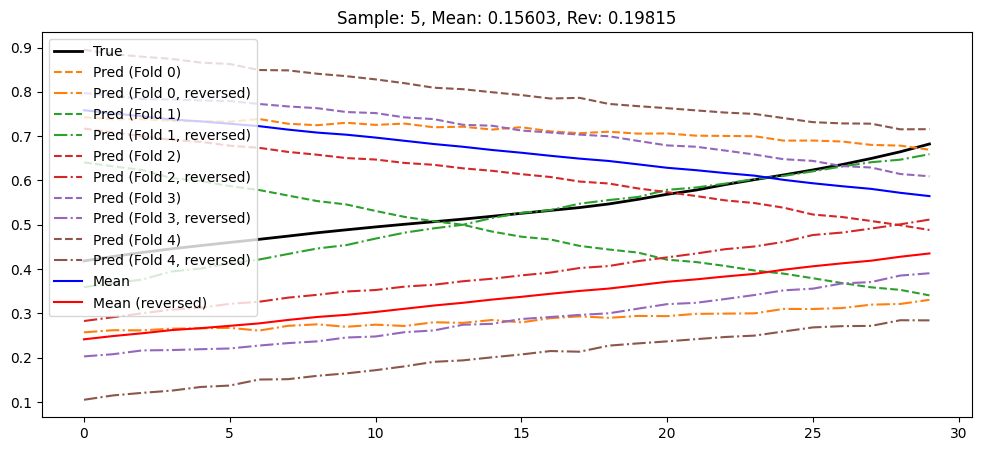

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


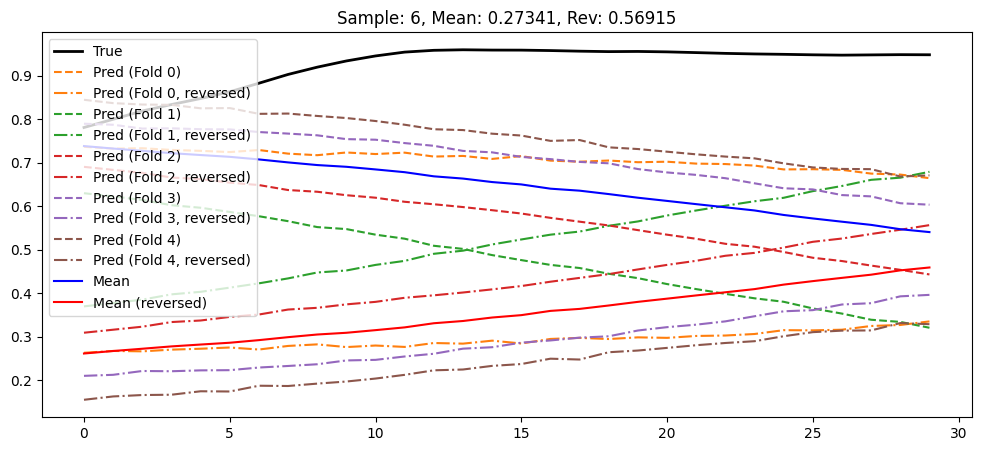

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


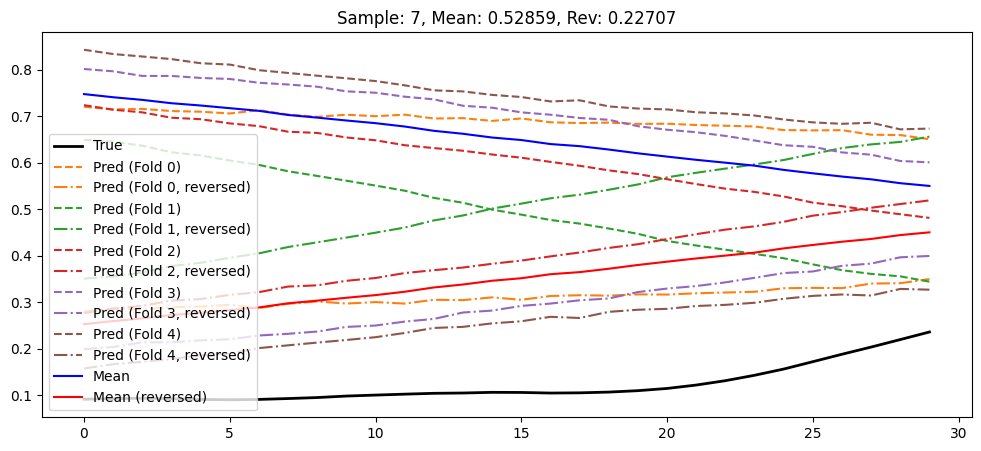

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


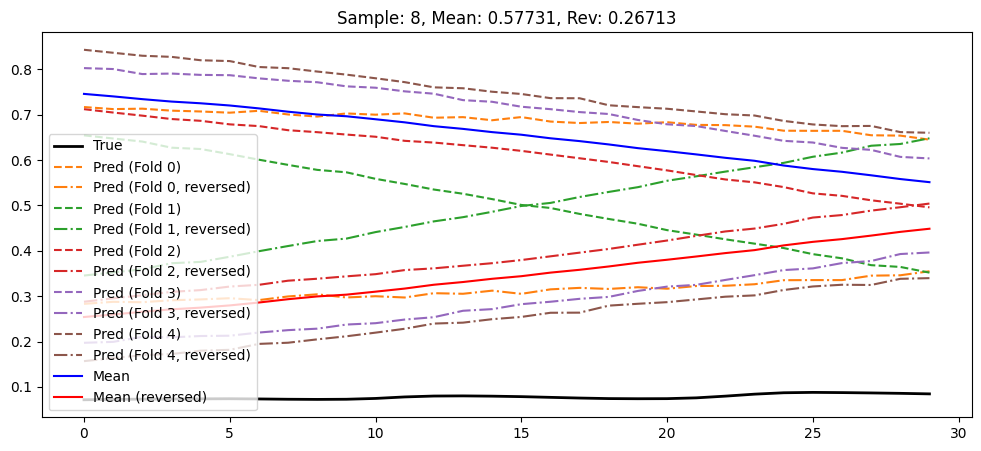

/tmp/ipykernel_75793/1505916781.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")


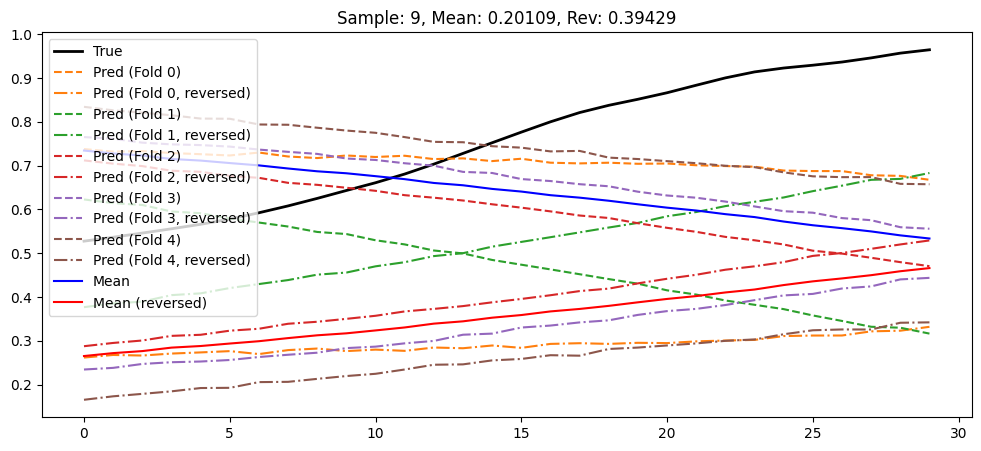

In [88]:
from sklearn.metrics import mean_absolute_error

def show_test_pred(sample_id: int=0):
    sample_x = test_x[sample_id, :, :].transpose(1, 0).reshape(1, 16, 1000)
    sample_y = test_y[sample_id, :, 0]
    preds = []
    fig = plt.figure(figsize=(12, 5))
    plt.plot(sample_y, label="True", lw=2, color="black")
    for i in range(num_splits):
        model = torch.load(f"../models/Fold{i}_Axis0_BestEpoch.pt")
        model.to("cpu")
        pred_y = model(torch.tensor(sample_x, dtype=torch.float32)).detach().numpy()
        preds.append(pred_y[0])
        plt.plot(pred_y[0], label=f"Pred (Fold {i})", ls="--", color=f"C{i+1}")
        plt.plot((pred_y[0]-1)*-1, label=f"Pred (Fold {i}, reversed)", ls="-.", color=f"C{i+1}")
    
    mean_pred = (np.mean(preds, axis=0)) 
    pred_rev = (mean_pred-1)*-1
    plt.plot(mean_pred, label="Mean", color="Blue", lw=1.5)
    plt.plot(pred_rev, label="Mean (reversed)", color="Red", lw=1.5)

    mean_error = mean_absolute_error(sample_y, mean_pred)
    mean_rev_error = mean_absolute_error(sample_y, pred_rev)
    plt.legend()
    plt.title(f"Sample: {sample_id}, Mean: {mean_error:.5f}, Rev: {mean_rev_error:.5f}")
    plt.show()
    
    

for i in range(10):
    show_test_pred(i)